In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.base import clone
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from scipy.stats import randint, uniform, loguniform

from outdated.my_settings import log_transform_config, plotting, use_best_params
from outdated.my_settings import one_hot as one_hot_encode

print(log_transform_config)
print(plotting, one_hot_encode, use_best_params)
plotting = True

{'age_mean_mass': False, 'velDisp_ppxf_res': True, 'MgFe': False, '[M/H]_mean_mass': False}
False False True


In [3]:
def preprocess_data(df, selected_features, log_transform_features=None, one_hot_encode=False):
    X = df[selected_features].copy()
    
    # Store original MgFe for potential restoration
    original_mgfe = X['MgFe'].copy() if 'MgFe' in X.columns else None
    
    if one_hot_encode and 'MgFe' in X.columns:
        # Define bins and labels
        bins = [0.0, 0.1, 0.2, 0.3, 0.4, np.inf]
        mgfe_labels = ['MgFe_0.0', 'MgFe_0.1', 'MgFe_0.2', 'MgFe_0.3', 'MgFe_0.4']
        
        # Create binned version
        X['MgFe_binned'] = pd.cut(X['MgFe'], 
                                 bins=bins, 
                                 labels=mgfe_labels, 
                                 include_lowest=True, 
                                 right=False)
        
        # One-hot encode the binned column
        mgfe_encoded = pd.get_dummies(X['MgFe_binned'], prefix='', prefix_sep='')
        
        # Drop original and binned MgFe columns
        X = X.drop(['MgFe', 'MgFe_binned'], axis=1)
        
        # Add encoded columns
        X = pd.concat([X, mgfe_encoded], axis=1)
    
    if log_transform_features is None:
        log_transform_features = {
            'age_mean_mass': False,
            'velDisp_ppxf_res': False,
            '[M/H]_mean_mass': False
        }

    for feature, do_log in log_transform_features.items():
        if do_log and feature in X.columns:
            X[feature] = np.log10(X[feature] + 1e-10)
    
    return X, X.columns.tolist(), original_mgfe

def restore_original_mgfe(df, original_mgfe, mgfe_labels=None):
    if mgfe_labels is None:
        mgfe_labels = ['MgFe_0.0', 'MgFe_0.1', 'MgFe_0.2', 'MgFe_0.3', 'MgFe_0.4']
    
    # Remove one-hot columns
    df = df.drop(columns=[col for col in df.columns if col in mgfe_labels])
    
    # Restore original MgFe
    if original_mgfe is not None:
        df['MgFe'] = original_mgfe
    
    return df

In [4]:
def plot_feature_importance(model, feature_names):
    """Plot feature importances for models that support them."""
    if hasattr(model.named_steps['regressor'], 'feature_importances_'):
        importance = model.named_steps['regressor'].feature_importances_
        indices = np.argsort(importance)[::-1]
        
        if plotting:
            plt.figure(figsize=(10, 6))
            plt.title("Feature Importances")
            plt.bar(range(len(importance)), importance[indices])
            plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45)
            plt.tight_layout()
            plt.show()

        # Print numerical values
        for i in indices:
            print(f"{feature_names[i]}: {importance[i]:.4f}")
    else:
        print("This model doesn't support feature importances")

def plot_regression_results(y_true, y_pred, model_name):
    """Plot regression results with metrics."""
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(y_true, y_pred, alpha=0.5)

    # Diagonal line for perfect predictions
    min_val, max_val = 0, 1
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    ax.set_title(f'{model_name} Regression Results')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')

    text = (f'R² = {r2:.3f}\n'
            f'RMSE = {rmse:.3f}\n'
            f'MAE = {mae:.3f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    return fig

In [5]:
def fit_and_evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test):
    """Train a model and evaluate its performance."""
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    return {
        'r2_score': r2_score(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'mae': mean_absolute_error(y_test, y_pred),
        'y_pred': y_pred
    }

def get_feature_importances(model, X, random_state, plotting=False):
    """Extract and optionally plot feature importances from a model."""
    if not hasattr(model, 'feature_importances_') and not hasattr(model, 'coef_'):
        return None
    
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:  # For Lasso and Ridge
        coef = np.abs(model.coef_)
        importance = coef / np.sum(coef)
    
    indices = np.argsort(importance)[::-1]
    
    if plotting:
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importances (Seed {random_state})")
        plt.bar(range(len(importance)), importance[indices])
        plt.xticks(range(len(importance)), [X.columns[i] for i in indices], rotation=45)
        plt.tight_layout()
        plt.show()
        
    return importance

def setup_random_search(model_name, model_info, random_state, n_iter = 100):
    base_params = {
        'n_iter': n_iter,
        'cv': 5,
        'scoring': 'neg_mean_squared_error',
        'random_state': random_state,
        'n_jobs': -1,
        'verbose': 1
    }
    
    estimator_map = {
        'XGBoost': XGBRegressor(
            objective='reg:squarederror',
            enable_categorical=False,
            random_state=random_state
        ),
        'RandomForest': RandomForestRegressor(random_state=random_state),
        'Lasso': Lasso(random_state=random_state),
        'Ridge': Ridge(random_state=random_state)
    }
    
    return RandomizedSearchCV(
        estimator=estimator_map[model_name],
        param_distributions=model_info['params'],
        **base_params
    )

def print_results_summary(results, X, feature_names):
    """Print average results and save feature importances and best parameters across seeds."""
    print("\n=== Average Results Across Seeds ===")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"R² Score: {np.mean(metrics['r2_scores']):.4f} ± {np.std(metrics['r2_scores']):.4f}")
        print(f"RMSE: {np.mean(metrics['rmse_scores']):.4f} ± {np.std(metrics['rmse_scores']):.4f}")
        print(f"MAE: {np.mean(metrics['mae_scores']):.4f} ± {np.std(metrics['mae_scores']):.4f}")
        
        # Save best parameters if available
        if 'best_params' in metrics and metrics['best_params']:
            print("\nBest Parameters Across Seeds:")
            params_df = pd.DataFrame([p['params'] for p in metrics['best_params']])
            
            print("\nParameter Statistics:")
            print(params_df.describe())
            
            print("\nCV Scores for Best Parameters:")
            for param_info in metrics['best_params']:
                print(f"Seed {param_info['seed']}: {param_info['cv_score']:.4f}")
            
            # Save parameters
            os.makedirs('../data/regression_results', exist_ok=True)
            params_df.to_csv(f'../data/regression_results/{name}_best_params.csv', index=False)
        
        # Calculate and save feature importances
        if metrics['importances']:
            mean_importance = np.mean(metrics['importances'], axis=0)
            std_importance = np.std(metrics['importances'], axis=0)
            
            print("\nAverage Feature Importances:")
            for i, (mean, std) in enumerate(zip(mean_importance, std_importance)):
                print(f"{X.columns[i]}: {mean:.4f} ± {std:.4f}")
            
            # Create DataFrame with feature importances and save
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Mean_Importance': mean_importance,
                'Std_Importance': std_importance
            })
            
            # Sort by mean importance before saving
            importance_df = importance_df.sort_values('Mean_Importance', ascending=False)
            
            # Save importances
            os.makedirs('../data/regression_results', exist_ok=True)
            importance_df.to_csv(f'../data/regression_results/{name}_avg.csv', index=False)

def comprehensive_regression_analysis(X, y, test_size=0.2, seeds=[42], n_iter=100):
    """Main function to perform comprehensive regression analysis."""
    all_results = {name: {'r2_scores': [], 'rmse_scores': [], 'mae_scores': [], 'importances': [],             'best_params': []} 
                  for name in models.keys()}
    
    for random_state in seeds:
        print(f"\nRunning with random seed {random_state}")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        for name, model_info in models.items():
            print(f"\nEvaluating {name}...")
            
            if model_info['params']:
                random_search = setup_random_search(name, model_info, random_state, n_iter)
                random_search.fit(X_train_scaled, y_train)
                best_model = random_search.best_estimator_
                print("Best Parameters:", random_search.best_params_)
                
                all_results[name]['best_params'].append({
                    'seed': random_state,
                    'params': random_search.best_params_,
                    'cv_score': random_search.best_score_
                })
                evaluation = fit_and_evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train, y_test)
            else:
                model = clone(model_info['model'])
                evaluation = fit_and_evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
            
            # Store results
            all_results[name]['r2_scores'].append(evaluation['r2_score'])
            all_results[name]['rmse_scores'].append(evaluation['rmse'])
            all_results[name]['mae_scores'].append(evaluation['mae'])
            
            importance = get_feature_importances(best_model if model_info['params'] else model, X, random_state, plotting)
            if importance is not None:
                all_results[name]['importances'].append(importance)
            
            if plotting:
                plot_regression_results(y_test, evaluation['y_pred'], f"{name} (Seed {random_state})")
                plt.show()

    print_results_summary(all_results, X, feature_names)
    return all_results


In [6]:
df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
np.random.seed(42)

In [7]:
models = {
    'RandomForest': {
        'model': None,
        'params': {
            'n_estimators': randint(400, 600),      # Wider range to ensure we're not missing better values
            'max_depth': randint(10, 30),             # Include shallower and deeper trees
            'min_samples_split': randint(2, 20),     # Include more conservative splits
            'max_features': uniform(0.2, 0.8),       # Wider feature consideration range
            'max_samples': uniform(0.3, 0.7),        # This range is good as is
            'min_samples_leaf': randint(1, 6)        # Allow for more conservative leaf sizes
        }
    },
}
all = { 
    'XGBoost': {
        'model': None,
        'params': {
            # Current parameters
            'n_estimators': randint(200, 500),    
            'max_depth': randint(3, 15),           
            'learning_rate': loguniform(0.01, 0.3),  
            'subsample': uniform(0.3, 0.7),        
            'min_child_weight': randint(3, 7),
            'colsample_bytree': uniform(0.3, 0.7),  # Fraction of features to use per tree
            'gamma': loguniform(0.005, 0.1),         # Minimum loss reduction for split
            'reg_alpha': loguniform(0.001, 0.01),      # L1 regularization
            'reg_lambda': loguniform(0.1, 1),     # L2 regularization
            }
    },
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
        'Lasso': {
        'model': None,
        'params': {
            'alpha': loguniform(1e-4, 1),
            'max_iter': [2000],  # Increased max iterations to ensure convergence
            'tol': loguniform(1e-6, 1e-4)
        }
    },
    'Ridge': {
        'model': None,
        'params': {
            'alpha': loguniform(1e-4, 1),
            'max_iter': [2000],
            'tol': loguniform(1e-6, 1e-4)
        }
    },
}


Using best parameters: {'max_depth': 22, 'max_features': 0.793, 'max_samples': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 460}

Test Set Performance:
R² Score: 0.7911
RMSE: 0.0742
MAE: 0.0549

Feature Importances:
MgFe: 0.0349
[M/H]_mean_mass: 0.3333
velDisp_ppxf_res: 0.1017
age_mean_mass: 0.5302


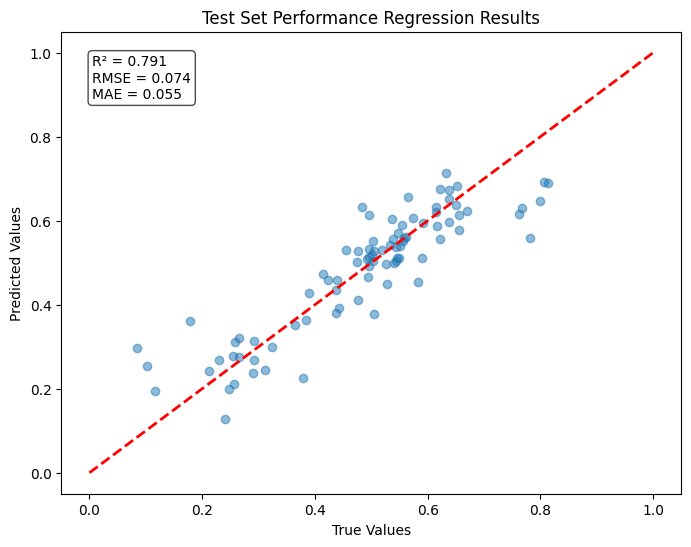


Full Dataset Performance:
R² Score: 0.8401
RMSE: 0.0597
MAE: 0.0411


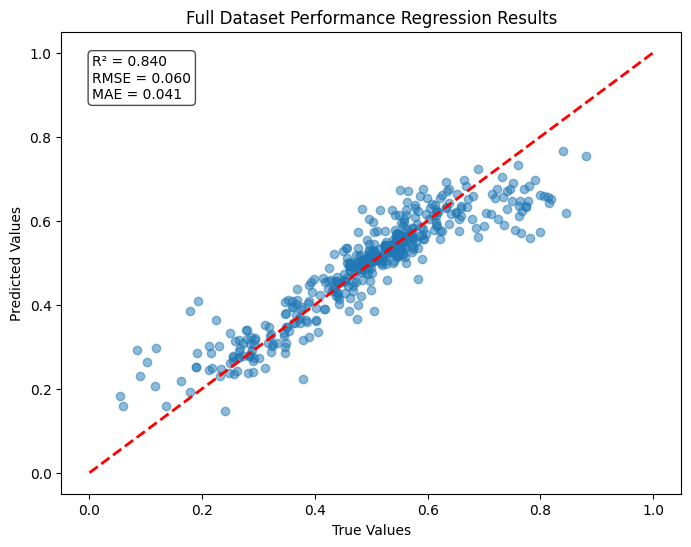

In [10]:
# Select features for the analysis
selected_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']

# Preprocess data
X, feature_names, original_mgfe = preprocess_data(
    df, 
    selected_features, 
    log_transform_features=log_transform_config,
    one_hot_encode=one_hot_encode
)
y = df['DoR'].values
seeds = [42,43,45]
if not use_best_params:
    results = comprehensive_regression_analysis(X, y, test_size=0.2, seeds=seeds, n_iter=500)
else:
    best_params = pd.read_csv('../data/regression_results/RandomForest_best_params.csv').mean()
    
    best_params = {
       'max_depth': int(round(best_params['max_depth'])),  # Round to nearest integer
       'max_features': round(best_params['max_features'], 3),
       'max_samples': round(best_params['max_samples'], 3),
       'min_samples_leaf': int(best_params['min_samples_leaf']),
       'min_samples_split': int(round(best_params['min_samples_split'])),
       'n_estimators': int(round(best_params['n_estimators']))
    }
    
    print("Using best parameters:", best_params)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train model with best params
    rf = RandomForestRegressor(**best_params)

    rf.fit(X_train_scaled, y_train)
    
    # Get predictions for test set
    y_pred = rf.predict(X_test_scaled)
    
    # Calculate and print metrics for test set
    print("\nTest Set Performance:")
    print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    
    # Print feature importances
    print("\nFeature Importances:")
    for feature, importance in zip(feature_names, rf.feature_importances_):
        print(f"{feature}: {importance:.4f}")
    
    # Plot test set results
    if plotting:
        fig = plot_regression_results(y_test, y_pred, "Test Set Performance")
        plt.show()
        
    # Now for full dataset
    print("\nFull Dataset Performance:")
    X_full_scaled = scaler.fit_transform(X)  # Scale the full dataset
    y_full_pred = rf.predict(X_full_scaled)
    
    print(f"R² Score: {r2_score(y, y_full_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y, y_full_pred)):.4f}")
    print(f"MAE: {mean_absolute_error(y, y_full_pred):.4f}")
    
    if plotting:
        fig = plot_regression_results(y, y_full_pred, "Full Dataset Performance")
        plt.show()

if one_hot_encode:  
    X = restore_original_mgfe(X, original_mgfe)

In [9]:
def form_regression_clusters(df, value_1=0.3, value_2=0.6):
    # Create SDSS identifiers
    sdss_ids = [f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
                for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])]
    
    # Assign clusters based on DoR values
    dor_labels = np.zeros(len(df), dtype=int)
    dor_labels[(df['DoR'] >= value_1) & (df['DoR'] < value_2)] = 1
    dor_labels[df['DoR'] < value_1] = 2
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'SDSS_ID': sdss_ids,
        'Cluster': dor_labels
    })
    
    # Create output directory if it doesn't exist
    os.makedirs('../data/cluster_results', exist_ok=True)
    
    # Save results
    filename = '../data/cluster_results/regression_tails_clusters.csv'
    results_df.to_csv(filename, index=False)
    
    # Print summary
    print("\nCluster Summary:")
    for i, label in enumerate(['High DoR', 'Medium DoR', 'Low DoR']):
        mask = dor_labels == i
        print(f"Cluster {i} ({label}): {mask.sum()} galaxies")
        print(f"Mean DoR: {df.loc[mask, 'DoR'].mean():.3f}")

form_regression_clusters(df, value_1=0.2, value_2=0.65)


Cluster Summary:
Cluster 0 (High DoR): 54 galaxies
Mean DoR: 0.738
Cluster 1 (Medium DoR): 361 galaxies
Mean DoR: 0.471
Cluster 2 (Low DoR): 15 galaxies
Mean DoR: 0.136
